In [0]:
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint

import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation
from matplotlib import pyplot
from tensorflow.keras import backend

import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from dask.array.image import imread
from skimage.transform import resize
import pickle

In [0]:
# custom activation function
def custom_activation(output):
    logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

In [0]:
# supervised and unsupervised discriminator models
def define_discriminator(in_shape=(128,128,1), n_classes=10):
    in_image = Input(shape=in_shape)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    fe = Dense(n_classes)(fe)
    c_out_layer = Activation('softmax')(fe)
    # define and compile supervised discriminator model
    c_model = Model(in_image, c_out_layer)
    c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    # unsupervised output
    d_out_layer = Lambda(custom_activation)(fe)
    # define and compile unsupervised discriminator model
    d_model = Model(in_image, d_out_layer)
    d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return d_model, c_model

In [0]:
# generator model
def define_generator(latent_dim):
    in_lat = Input(shape=(latent_dim,))
    n_nodes = 128 * 32 * 32
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((32,32, 128))(gen)
    # upsample to 64x64
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 128x128
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model(in_lat, out_layer)
    return model

In [0]:
# combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
# load the images
def load_real_samples(trainset_label=False):
    with open("/content/drive/My Drive/X_train.pickle","rb") as f:
        X_train=pickle.load(f)
    with open("/content/drive/My Drive/X_unlab.pickle","rb") as f:
        X_unlab=pickle.load(f)
    with open("y_train.pickle","rb") as f:
        y_train=pickle.load(f)
    with open("y_unlab.pickle","rb") as f:
        y_unlab=pickle.load(f)
    with open("/content/drive/My Drive/X_val.pickle","rb") as f:
        X_test=pickle.load(f)
    with open("y_val.pickle","rb") as f:
        y_test=pickle.load(f)
    trainX=np.concatenate((X_train,X_unlab))
    trainy=np.concatenate((y_train,y_unlab))
    X = trainX.astype('float32')
    print(X.shape, trainy.shape)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    return [X, trainy],[X_train.astype('float32'), y_train],[X_test.astype('float32'),y_test]

In [0]:
# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=15000, n_classes=10):
    X, y = dataset
    X_list, y_list = list(), list()
    n_per_class = int(n_samples / n_classes)
    for i in range(n_classes):
    # get all images for this class
    X_with_class = X[y == i]
    # choose random instances
    ix = randint(0, len(X_with_class), n_per_class)
    # add to list
    [X_list.append(X_with_class[j]) for j in ix]
    [y_list.append(i) for j in ix]
    return asarray(X_list), asarray(y_list)

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    y = ones((n_samples, 1))
    return [X, labels], y

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    z_input = randn(latent_dim * n_samples)
    z_input = z_input.reshape(n_samples, latent_dim)
    return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)
    y = zeros((n_samples, 1))
    return images, y

In [0]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim,dataset,train_label,val_label,n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # evaluate the classifier model
    X, y = train_label
    _, acc = c_model.evaluate(X, y, verbose=0)
    print('Train Accuracy: %.3f%%' % (acc * 100))
      # evaluate the validation set
    X_val, y_val = val_label
    _, acc_val = c_model.evaluate(X_val, y_val, verbose=0)
    print('validation Accuracy: %.3f%%' % (acc_val * 100))

    # save the generator model
    filename2 = 'g_model_%04d.h5' % (step+1)
    g_model.save(filename2)
    # save the classifier model
    filename3 = 'c_model_%04d.h5' % (step+1)
    c_model.save(filename3)
    print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [0]:
# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, dataset, train_label,val_label,latent_dim, n_epochs=5, n_batch=100):
    #supervised dataset
    X_sup, y_sup = select_supervised_samples(dataset)
    print(X_sup.shape, y_sup.shape)
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
    # manually enumerate epochs
    for i in range(n_steps):
        # update supervised discriminator (c)
        [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
        c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
        # update unsupervised discriminator (d)
        [X_real, _], y_real = generate_real_samples(dataset, half_batch)
        d_loss1 = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_loss2 = d_model.train_on_batch(X_fake, y_fake)
        # update generator (g)
        X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
        # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, c_model, latent_dim, dataset,train_label,val_label)

In [18]:
# size of the latent space
latent_dim = 100
d_model, c_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset,train_label,test_label= load_real_samples()
# train model
train(g_model, d_model, c_model, gan_model, dataset,train_label,test_label, latent_dim)

(55024, 128, 128, 1) (55024,)
(15024, 128, 128, 1) (15024,)
(7400, 128, 128, 1) (7400,)
(15000, 128, 128, 1) (15000,)
n_epochs=5, n_batch=100, 1/2=50, b/e=550, steps=2750
>1, c[2.306,10], d[0.097,2.399], g[0.095]
>2, c[2.303,8], d[0.087,2.396], g[0.096]
>3, c[2.299,18], d[0.076,2.392], g[0.097]
>4, c[2.286,14], d[0.059,2.390], g[0.099]
>5, c[2.268,12], d[0.043,2.382], g[0.104]
>6, c[2.306,8], d[0.043,2.300], g[0.120]
>7, c[2.307,16], d[0.075,2.129], g[0.151]
>8, c[2.325,8], d[0.081,1.986], g[0.182]
>9, c[2.296,16], d[0.086,1.785], g[0.239]
>10, c[2.221,20], d[0.030,1.496], g[0.377]
>11, c[2.345,12], d[0.074,0.985], g[0.763]
>12, c[2.309,12], d[0.018,0.463], g[1.553]
>13, c[2.286,22], d[0.008,0.200], g[2.265]
>14, c[2.294,20], d[0.010,0.097], g[2.805]
>15, c[2.301,10], d[0.012,0.057], g[3.208]
>16, c[2.226,22], d[0.002,0.047], g[3.412]
>17, c[2.312,10], d[0.003,0.054], g[3.440]
>18, c[2.282,22], d[0.006,0.046], g[4.044]
>19, c[2.189,20], d[0.008,0.081], g[6.245]
>20, c[2.196,16], d[0.05

In [19]:
from tensorflow.keras.models import load_model
model=load_model('c_model_2750.h5')

In [0]:
x,y=train_label
x_test,y_test=test_label

In [21]:
l,acc=model.evaluate(x,y,verbose=0)
print('train acc %.2f'%(acc*100))
ll,acc_t=model.evaluate(x_test,y_test,verbose=0)
print('test acc %.2f'%(acc_t*100))

train acc 95.55
test acc 94.70


In [0]:
pred=model.predict(x_test)

In [0]:
with open("prediction.pickle","wb") as f:
  pickle.dump(pred,f)

In [0]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

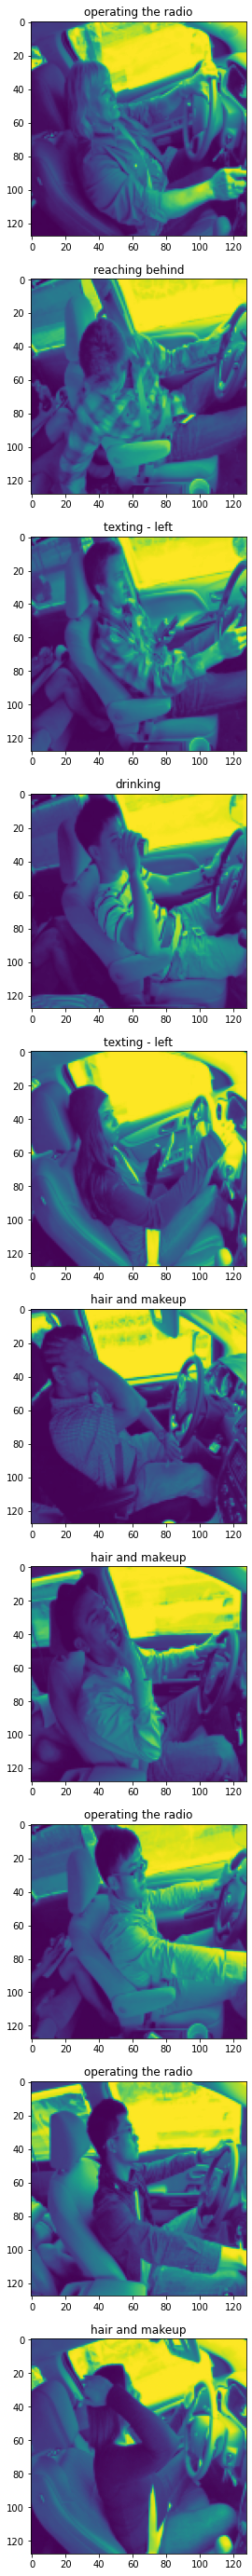

In [87]:
# labels is the image array
import matplotlib.pyplot as plt
i = 0
fig, ax = plt.subplots(10,1,figsize=(50, 50))
for i in range(10):
    predicted_class = 'C'+str(np.where(pred[i] == np.amax(pred[i]))[0][0])
    ax[i].imshow(x_test[i].squeeze())
    ax[i].set_title(tags[predicted_class])



In [0]:
from tensorflow.keras.utils import plot_model

In [0]:
discriminator_model=define_discriminator()

In [91]:
print(discriminator_model[0].summary())

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 128)       1280      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 16, 16, 128)       0  

In [92]:
print(discriminator_model[1].summary())

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 128)       1280      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 16, 16, 128)       0  

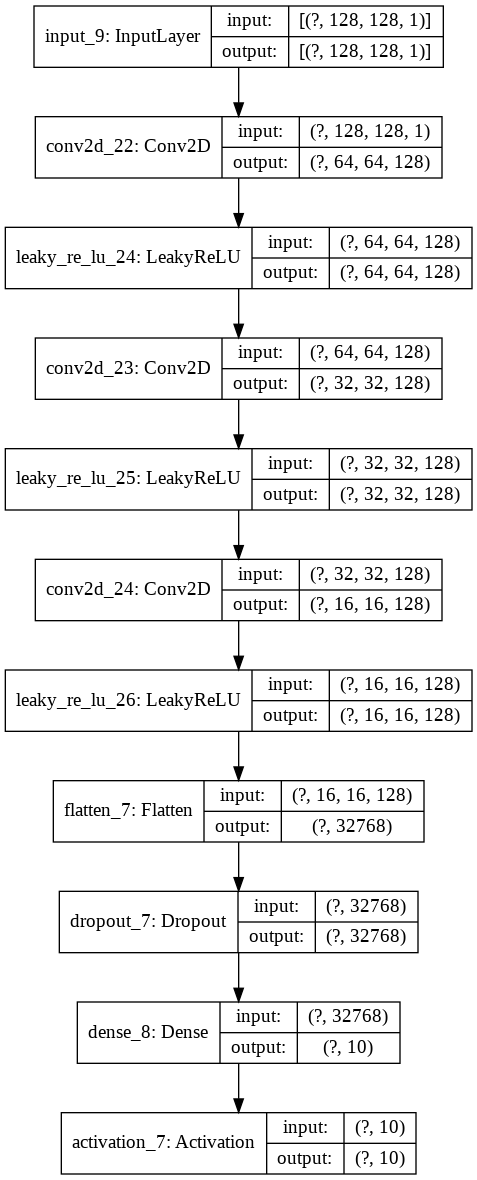

In [93]:
plot_model(discriminator_model[1], to_file='Supervised Discriminator Model.png', show_shapes=True, show_layer_names=True)


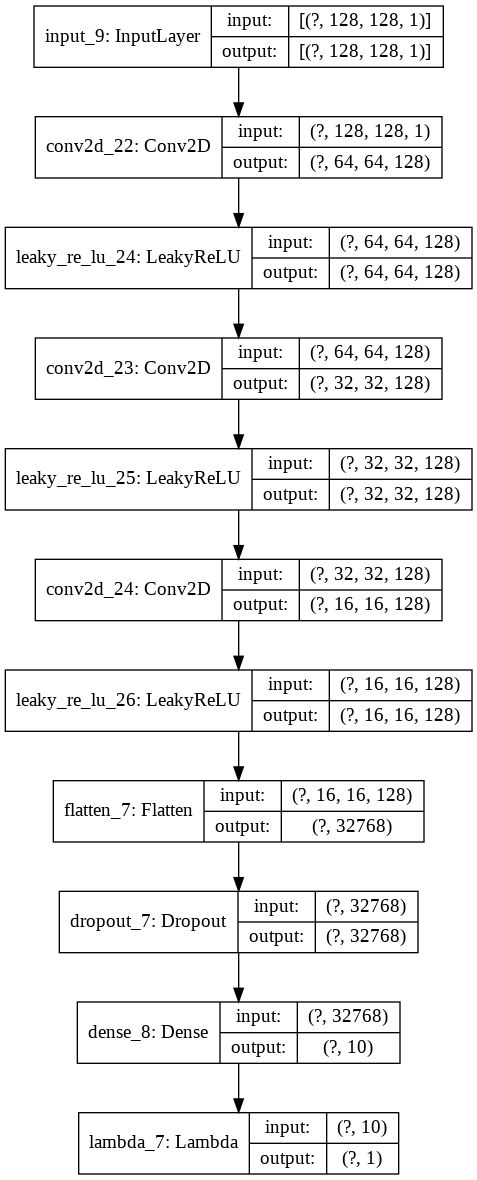

In [94]:
plot_model(discriminator_model[0], to_file='Unsupervised Discriminator Model.png', show_shapes=True, show_layer_names=True)
